In [2]:
import os
import sys
import requests
import numpy as np
import pandas as pd
from typing import List

# Kiểm tra robots.txt để xác định xem có cho phép thu thập dữ liệu hay không.
import urllib.robotparser

# URL cơ sở được sử dụng trong tất cả các lệnh gọi API
BASE_URL = 'http://api.worldbank.org/v2/'

# Danh sách các chỉ số theo đặc điểm được xác định ở trên
INDICATOR_CODES = ['SP.POP.TOTL', 'SP.POP.TOTL.FE.IN', 'SP.POP.TOTL.MA.IN', 'SP.DYN.CBRT.IN',
                   'SP.DYN.CDRT.IN', 'SE.COM.DURS', 'SL.IND.EMPL.ZS', 'SL.AGR.EMPL.ZS', 'SL.AGR.EMPL.FE.ZS',
                   'SL.IND.EMPL.FE.ZS', 'SL.UEM.TOTL.ZS', 'NY.GDP.MKTP.CD', 'NY.ADJ.NNTY.PC.KD.ZG', 'NY.GSR.NFCY.CD',
                   'NV.AGR.TOTL.CD', 'EG.USE.ELEC.KH.PC', 'EG.FEC.RNEW.ZS', 'EG.USE.COMM.FO.ZS',
                   'SP.DYN.LE00.MA.IN', 'SP.DYN.LE00.FE.IN', 'SE.PRM.ENRR', 'SE.TER.ENRR', 'SE.PRM.CMPT.ZS',
                   'SE.ADT.1524.LT.ZS']

# Ánh xạ mã tính năng sang tên có ý nghĩa hơn
features_mapping = {
    "SP.POP.TOTL": "Total Population",
    "SP.POP.TOTL.FE.IN": "Female Population",
    "SP.POP.TOTL.MA.IN": "Male Population",
    "SP.DYN.CBRT.IN": "Birth Rate",
    "SP.DYN.CDRT.IN": "Death Rate",
    "SE.COM.DURS": "Compulsory Education Dur.",
    "SL.IND.EMPL.ZS": "Employment in Industry(%)",
    "SL.AGR.EMPL.ZS": "Employment in Agriculture(%)",
    "SL.AGR.EMPL.FE.ZS": "Female Employment in Agriculture(%)",
    "SL.IND.EMPL.FE.ZS": "Female Employment in Industry(%)",
    "SL.UEM.TOTL.ZS": "Unemployment(%)",
    "NY.GDP.MKTP.CD": "GDP in USD",
    "NY.ADJ.NNTY.PC.KD.ZG": "National Income per Capita",
    "NY.GSR.NFCY.CD": "Net income from Abroad",
    "NV.AGR.TOTL.CD": "Agriculture value added(in USD)",
    "EG.USE.ELEC.KH.PC": "Electric Power Consumption(kWH per capita)",
    "EG.FEC.RNEW.ZS": "Renewable Energy Consumption (%)",
    "EG.USE.COMM.FO.ZS": "Fossil Fuel Consumption (%)",
    "SP.DYN.LE00.MA.IN": "Male life expectancy",
    "SP.DYN.LE00.FE.IN": "Female life expectancy ",
    "SE.PRM.ENRR": "School enrollment, primary",
    "SE.TER.ENRR": "School enrollment, tertiary",
    "SE.PRM.CMPT.ZS": "Primary completion rate",
    "SE.ADT.1524.LT.ZS": "Literacy rate"
}

# Định nghĩa một số country codes
df_country_code = pd.read_csv("./country-codes.csv")
df_country_code = df_country_code.fillna("NA")
COUNTRIES_MAPPING = dict(zip(df_country_code["alpha-2-code"], df_country_code["name"]))
del df_country_code

def replacer(s, newstring, index, nofail=False):
    # raise an error if index is outside of the string
    if not nofail and index not in range(len(s)):
        raise ValueError("index outside given string")

    # if not erroring, but the index is still not in the correct range..
    if index < 0:  # add it to the beginning
        return newstring + s
    if index > len(s):  # add it to the end
        return s + newstring

    # insert the new string between "slices" of the original
    return s[:index] + newstring + s[index + 1:]

def loadData(country_code: str, format: str = "json", per_page: int = 100, year_interval: str = '2015:2022') -> List:
    # Danh sách dữ liệu
    dataLst = []

    # Tạo các tham số cho request
    start_year, end_year = year_interval.split(
        ':')[0], year_interval.split(':')[1]

    # Duyệt từng indicator được chỉ định trong hằng số INDICATOR_CODES được xác định ở trên
    for indicator in INDICATOR_CODES:
        # tạo URL theo định dạng mong muốn
        # Ví dụ: http://api.worldbank.org/v2/countries/us/indicators/SP.POP.TOTL?format=json&per_page=200&date=196
        url = BASE_URL+'countries/' + country_code.lower() + '/indicators/' + indicator

        # gửi request với các tham số mặc định bằng resquests module
        params = {'format': format,
                  'per_page': str(per_page),
                  'date': str(start_year) + ":" + str(end_year)}

        response = requests.get(url, params=params)

        # Xác thực mã trạng thái phản hồi
        # API trả về status_code 200 ngay cả đối với các thông báo lỗi,
        # tuy nhiên, nội dung phản hồi chứa một trường có tên là "thông báo" bao gồm các chi tiết về lỗi
        # kiểm tra xem tin nhắn có xuất hiện trong phản hồi hay không
        if response.status_code == 200 and ("message" not in response.json()[0].keys()):
            # print("Successfully got data for: " + str(featureMap[indicator]))

            # danh sách các giá trị cho một đặc trưng
            indicatorVals = []

            # phản hồi là một mảng chứa hai mảng - [[{page: 1, ...}], [{year: 2018, SP.POP.TOTL: 123455}, ...]]
            # do đó chúng ta kiểm tra xem độ dài của phản hồi có > 1 hay không
            if len(response.json()) > 1:

                # nếu có, lặp lại từng đối tượng trong phản hồi
                # mỗi đối tượng cho một giá trị duy nhất cho mỗi năm
                for obj in response.json()[1]:

                    # Kiểm tra giá trị rỗng
                    if (obj['value'] == "") or (obj['value'] is None):
                        indicatorVals.append('None')
                    else:
                        # nếu có một giá trị, hãy thêm nó vào danh sách các giá trị chỉ báo indicatorVals
                        indicatorVals.append(float(obj['value']))

                dataLst.append(indicatorVals)

            else:
                # In thông báo lỗi nếu lệnh gọi API không thành công
                print("Error in Loading the data. Status Code: " +
                      str(response.status_code))

    # Khi đã có được tất cả các đặc trưng, ta thêm các giá trị cho "Năm"
    # API trả về các giá trị indicator từ năm gần đây nhất. Do đó, chúng tôi tạo một danh sách các năm ngược lại
    dataLst.append([year for year in range(
        int(end_year), int(start_year)-1, -1)])

    # Trả về danh sách các giá trị đặc trưng [[val1,val2,val3...], [val1,val2,val3...], [val1,val2,val3...], .
    return dataLst

def loadDataCountry(country_code: str, format: str = "json", per_page: int = 100, year_interval: str = '2015:2022', is_display: bool = False) -> pd.DataFrame:
    # Định nghĩa một số country codes
    df_country_code = pd.read_csv("./country-codes.csv")
    df_country_code = df_country_code.fillna("NA")
    COUNTRIES_MAPPING = dict(
        zip(df_country_code["alpha-2-code"], df_country_code["name"]))
    del df_country_code

    # dataframe kết quả cần phải có tên cột có ý nghĩa
    # do đó chúng ta tạo danh sách tên cột từ ánh xạ các đặc trưng được xác định ở trên
    col_list = list(features_mapping.values())

    # Thêm cột "Year"
    col_list.append('Year')

    print(f"[LOG] Loading data for {COUNTRIES_MAPPING[country_code]}")

    # Với mã country code cho trước, gọi hàm loadData
    dataLst = loadData(country_code=country_code, format=format,
                       per_page=per_page, year_interval=year_interval)

    # Chuyển đổi danh sách các đặc trưng thành kiểu Pandas DataFrame
    df = pd.DataFrame(np.column_stack(dataLst), columns=col_list)

    # Thêm cột quốc gia bằng cách trích xuất tên quốc gia từ bản đồ bằng mã quốc gia
    df['Country'] = COUNTRIES_MAPPING[country_code]

    if is_display:
        from IPython.display import display
        display(df.head())

    return df

def loadDataContinent(continent: str = "Asia", format: str = "json", per_page: int = 100, year_interval: str = '2015:2022', is_display: bool = False) -> pd.DataFrame:
    if continent.lower() not in ['asia', 'europe', 'africa', 'oceania', 'americas']:
        print(
            f"[LOG] Please check input continent again. We don't support {continent}.")
        raise ValueError

    if not continent[0].isupper():
        continent = replacer(continent, continent[0].upper(), 0)

    # Định nghĩa một số country codes
    df_country_code = pd.read_csv("./country-codes.csv")
    df_country_code = df_country_code.fillna("NA")
    df_country_code = df_country_code[df_country_code["continent"] == continent]
    lst_country_codes = df_country_code["alpha-2-code"]
    del df_country_code

    df = pd.DataFrame()
    for country_code in lst_country_codes:
        df = pd.concat([df, loadDataCountry(
            country_code=country_code,
            format=format,
            per_page=per_page,
            year_interval=year_interval,
            is_display=False)], axis=0)

    if is_display:
        from IPython.display import display
        display(df.head())

    return df

def saveDataFrame2CSV(df: pd.DataFrame, save_path: str, sep: str = ',', encoding: str = 'utf-8') -> bool:
    try:
        df.to_csv(save_path, sep=sep, encoding=encoding, index=False)
    except:
        raise ModuleNotFoundError
        # return False
    return True

In [3]:
continent = "Asia"
format = "json"
per_page = 100
year_interval = '1995:2022'
is_display = True

df = loadDataContinent(
    continent=continent,
    format=format,
    per_page=per_page,
    year_interval=year_interval,
    is_display=is_display
)

[LOG] Loading data for Afghanistan
[LOG] Loading data for Armenia
[LOG] Loading data for Azerbaijan
[LOG] Loading data for Bahrain
[LOG] Loading data for Bangladesh
[LOG] Loading data for Bhutan
[LOG] Loading data for Brunei Darussalam
[LOG] Loading data for Cambodia
[LOG] Loading data for China
[LOG] Loading data for Cyprus
[LOG] Loading data for Georgia
[LOG] Loading data for India
[LOG] Loading data for Indonesia
[LOG] Loading data for Iran, Islamic Rep.
[LOG] Loading data for Iraq
[LOG] Loading data for Israel
[LOG] Loading data for Japan
[LOG] Loading data for Jordan
[LOG] Loading data for Kazakhstan
[LOG] Loading data for Korea, Dem. People’s Rep.
[LOG] Loading data for Korea, Rep.
[LOG] Loading data for Kuwait
[LOG] Loading data for Kyrgyz Republic
[LOG] Loading data for Lao PDR
[LOG] Loading data for Lebanon
[LOG] Loading data for Malaysia
[LOG] Loading data for Maldives
[LOG] Loading data for Mongolia


KeyboardInterrupt: 

In [ ]:
df.to_csv("data_asia.csv", index=False, na_rep='None')

### Basic level: 

***How many rows and columns are there in your data?***







In [3]:
df=pd.read_csv('./data_asia.csv')
num_rows, num_cols = df.shape
print(f"rows: {num_rows}")
print(f"columns: {num_cols}")


rows: 1316
columns: 26


***What is the meaning of each row/column?***

## For column 
**Total Population**: The total number of people in the country.

**Female Population**: The number of females in the country.

**Male Population**: The number of males in the country.

**Birth Rate**: The number of live births per thousand of the population per year.

**Death Rate**: The number of deaths per thousand of the population per year.

**Compulsory Education Dur.**: The number of years of compulsory education.

**Employment in Industry(%)**: Percentage of the workforce employed in the industry sector.

**Employment in Agriculture(%)**: Percentage of the workforce employed in the agriculture sector.

**Female Employment in Agriculture(%)**: Percentage of female workforce employed in the agriculture sector.

**Female Employment in Industry(%)**: Percentage of female workforce employed in the industry sector.

**Unemployment(%)**: The percentage of the workforce that is unemployed.

**GDP in USD**: Gross Domestic Product measured in US dollars.

**National Income per Capita**: The income earned by each individual in the country.

**Net income from Abroad**: The net income received from foreign sources.

**Agriculture value added(in USD)**: The value added in agriculture sector in US dollars.

**Electric Power Consumption(kWH per capita)**: Electricity consumed per capita.

**Renewable Energy Consumption (%)**: Percentage of energy consumed from renewable sources.

**Fossil Fuel Consumption (%)**: Percentage of energy consumed from fossil fuels.

**Male life expectancy**: Average life expectancy for males.

**Female life expectancy**: Average life expectancy for females.

**School enrollment, primary**: Enrollment rate in primary education.

**School enrollment, tertiary**: Enrollment rate in tertiary education.

**Primary completion rate**: Rate of primary school completion.

**Literacy rate**: The percentage of the population that can read and write.

**Year**: The year the data was recorded.

**Country**: The name of the country.

## For row 
Shows the data corresponding to each column of the data table

In [14]:
col_meaning_df = pd.read_csv('./data_asia.csv')
col_meaning_df.columns

Index(['Total Population', 'Female Population', 'Male Population',
       'Birth Rate', 'Death Rate', 'Compulsory Education Dur.',
       'Employment in Industry(%)', 'Employment in Agriculture(%)',
       'Female Employment in Agriculture(%)',
       'Female Employment in Industry(%)', 'Unemployment(%)', 'GDP in USD',
       'National Income per Capita', 'Net income from Abroad',
       'Agriculture value added(in USD)',
       'Electric Power Consumption(kWH per capita)',
       'Renewable Energy Consumption (%)', 'Fossil Fuel Consumption (%)',
       'Male life expectancy', 'Female life expectancy ',
       'School enrollment, primary', 'School enrollment, tertiary',
       'Primary completion rate', 'Literacy rate', 'Year', 'Country'],
      dtype='object')

***What is the datatype of each column?***

In [15]:
dtypes = df.dtypes
dtypes

Total Population                              float64
Female Population                             float64
Male Population                               float64
Birth Rate                                    float64
Death Rate                                    float64
Compulsory Education Dur.                     float64
Employment in Industry(%)                     float64
Employment in Agriculture(%)                  float64
Female Employment in Agriculture(%)           float64
Female Employment in Industry(%)              float64
Unemployment(%)                               float64
GDP in USD                                    float64
National Income per Capita                    float64
Net income from Abroad                        float64
Agriculture value added(in USD)               float64
Electric Power Consumption(kWH per capita)    float64
Renewable Energy Consumption (%)              float64
Fossil Fuel Consumption (%)                   float64
Male life expectancy        

**Is this suitable datatype for the column?**

These data types seem suitable for the corresponding columns, as they match the nature of the data they hold. Numerical data is stored as floats or integers, and categorical data like country names is stored as objects. This should allow you to perform various calculations, analyses, and visualizations effectively on this dataset in Python using pandas and other related libraries.

**What is the distribution of the data in each column?**

       Total Population  Female Population  Male Population   Birth Rate   
count      1.316000e+03       1.316000e+03     1.316000e+03  1269.000000  \
mean       9.020217e+07       4.433594e+07     4.586623e+07    20.700378   
std        2.549317e+08       1.240024e+08     1.309465e+08     7.833438   
min        2.582080e+05       1.249510e+05     1.332570e+05     5.100000   
25%        4.382818e+06       2.121473e+06     2.311564e+06    15.051000   
50%        1.822701e+07       9.013542e+06     9.061772e+06    19.841000   
75%        6.135766e+07       3.051728e+07     3.080141e+07    24.649000   
max        1.417173e+09       6.915285e+08     7.311805e+08    52.073000   

        Death Rate  Compulsory Education Dur.  Employment in Industry(%)   
count  1269.000000                1041.000000                1267.000000  \
mean      6.343087                   8.913545                  21.368640   
std       2.718865                   2.021095                   7.901133   
min       0

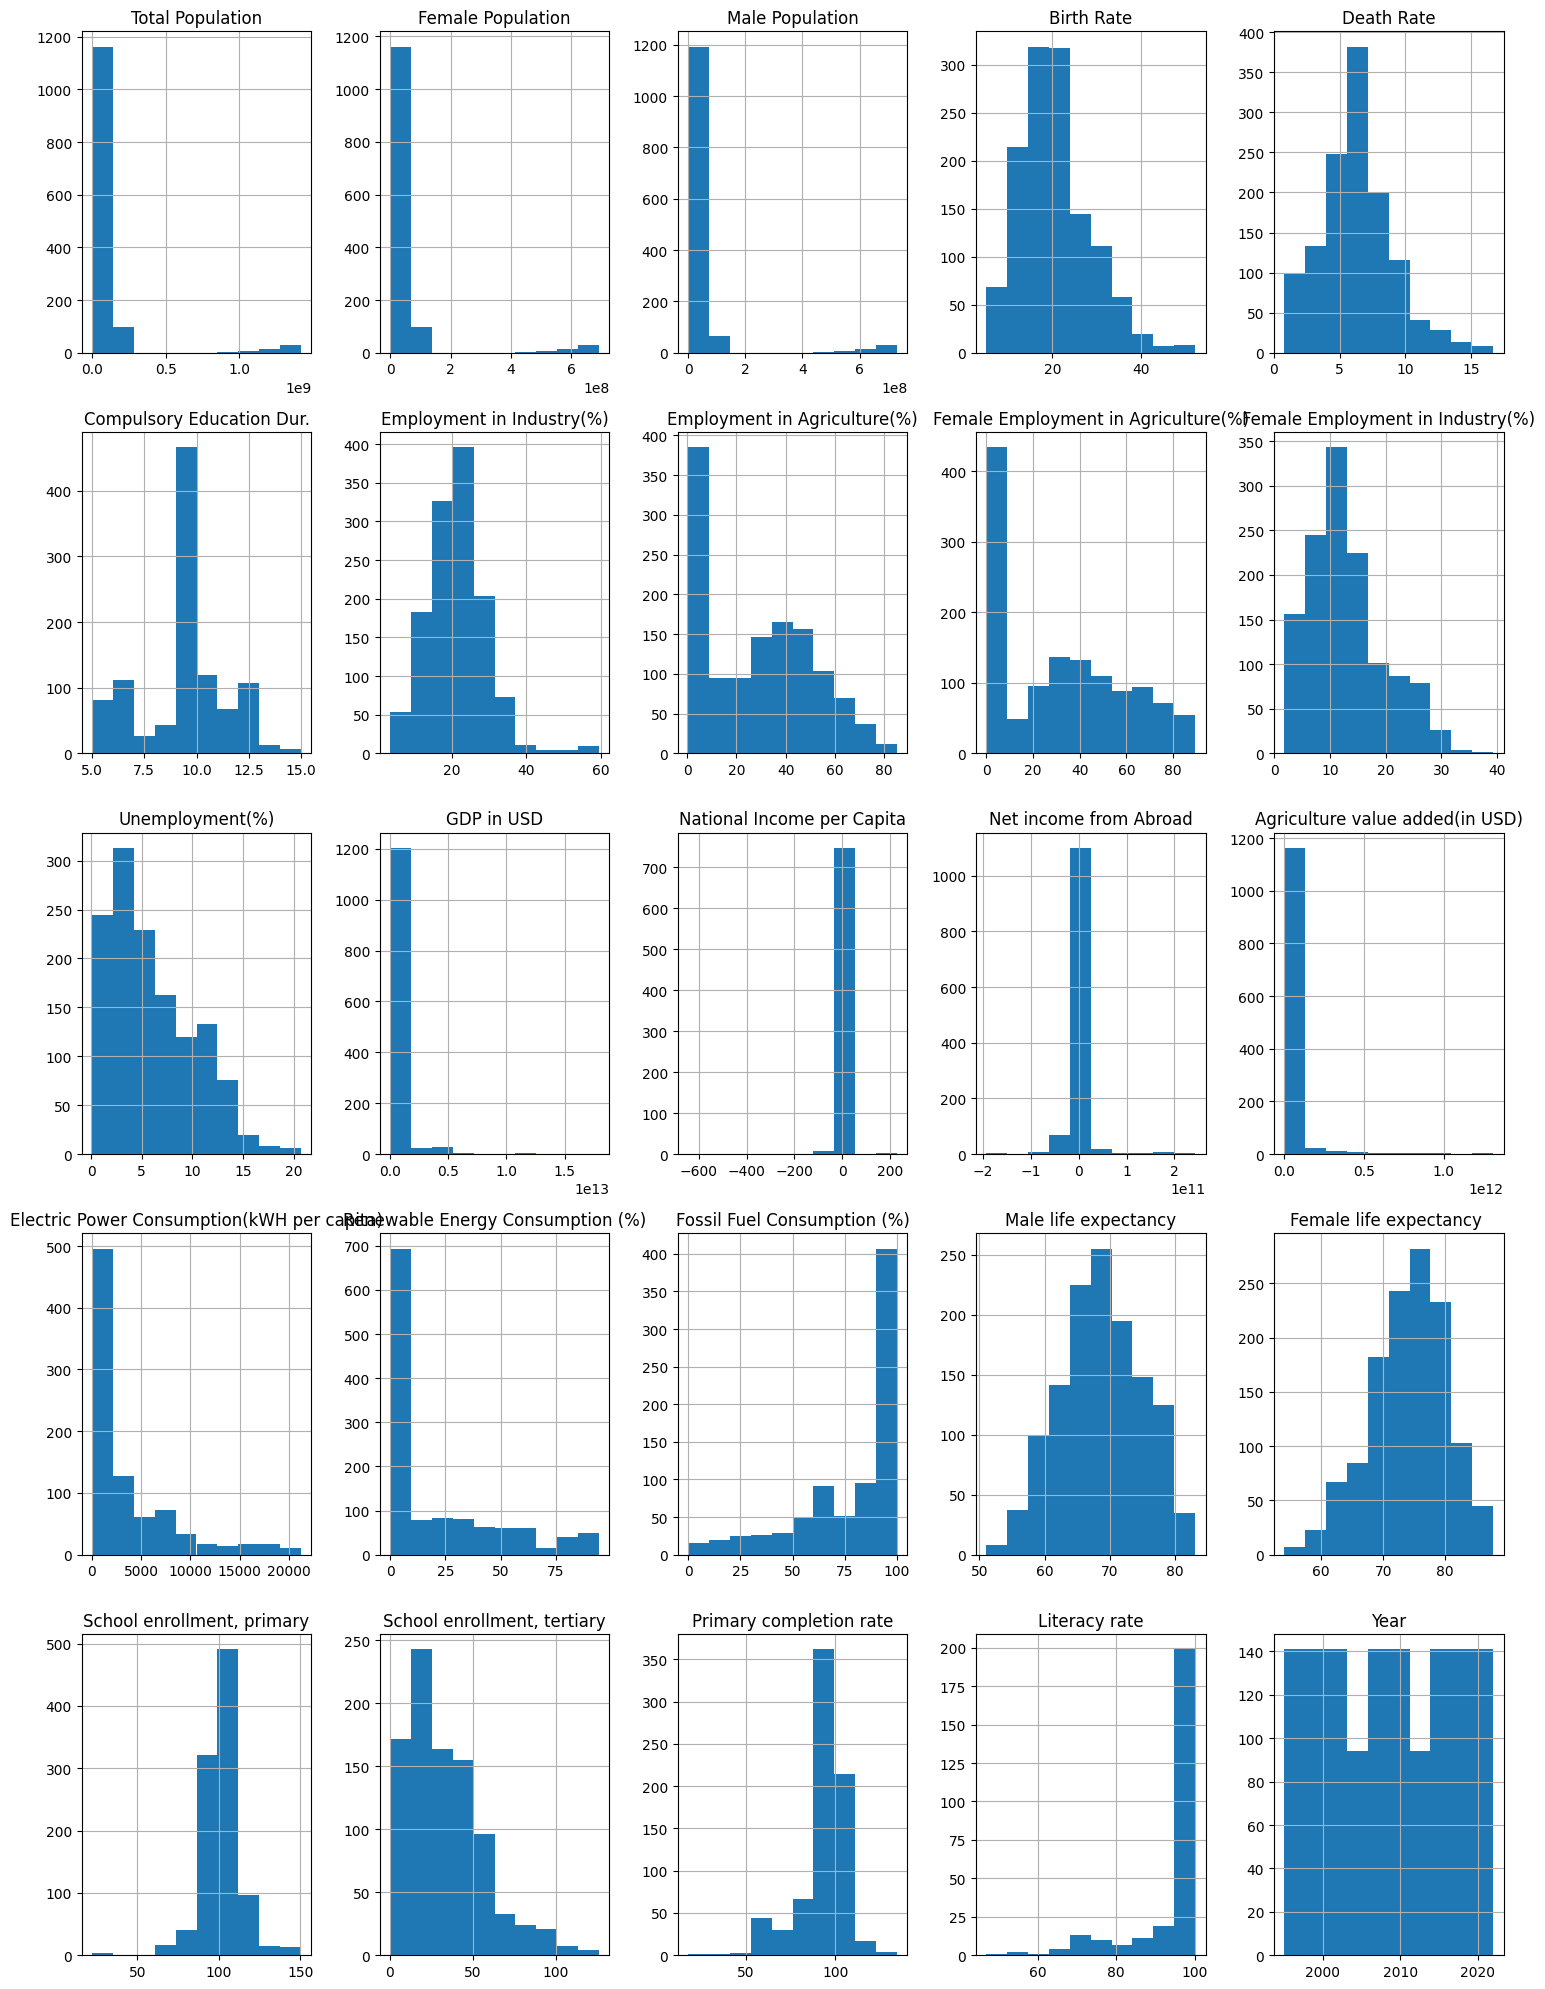

In [8]:
import matplotlib.pyplot as plt
data = df.copy()
data.drop(columns = ['Year'])
summary_stats = data.describe()
print(summary_stats)

data.hist(figsize=(15, 20))
plt.tight_layout()
plt.show()